# Import libraries

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import torchvision
import torch
from torch.utils.data import Subset, DataLoader
import sklearn.model_selection
from torch.utils.tensorboard import SummaryWriter

# Load images

(480, 640, 3)

dtype('uint8')

<IPython.core.display.Javascript object>


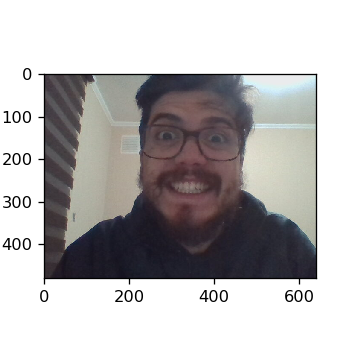

In [2]:
img = plt.imread("leo.jpg")

display(img.shape)
display(img.dtype)

plt.figure(figsize = (3,3))
plt.imshow(img, cmap = plt.cm.Greys_r)

<IPython.core.display.Javascript object>


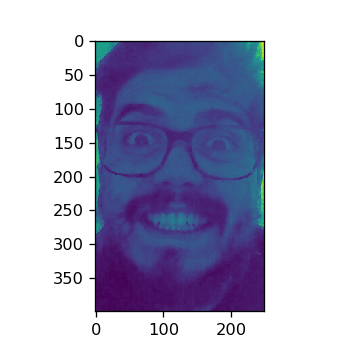

In [38]:
subimg = np.copy(img[0:400, 220:470, 2])
plt.figure(figsize = (3,3))
plt.imshow(subimg)

In [46]:
subimg2.shape

(250,)

<IPython.core.display.Javascript object>


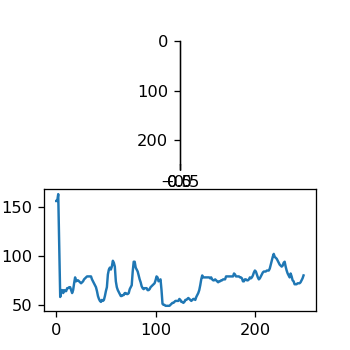

In [51]:
subimg2 = subimg[142, :].reshape(250, 1)

fig, ax = plt.subplots(2, 1, figsize = (3,3))
ax[0].imshow(subimg2)
ax[1].plot(subimg2)

# Convolution

array([[0., 0., 0.],
       [0., 2., 0.],
       [0., 0., 0.]])

(252, 3)

(250, 1)

<IPython.core.display.Javascript object>


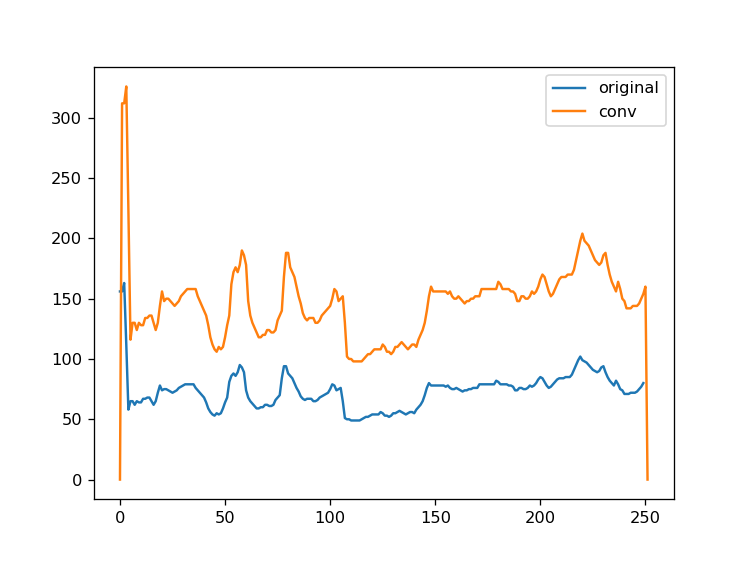

In [88]:
dim = 3
filt = np.zeros(shape = (dim, dim))
filt[1:-1, 1:-1] = 2
display(filt)
conv = scipy.signal.correlate(subimg2, filt)
display(conv.shape)
display(subimg2.shape)
plt.figure()
plt.plot(subimg2, label = "original")
plt.plot(conv[:,1], label = "conv")
plt.legend()

<IPython.core.display.Javascript object>


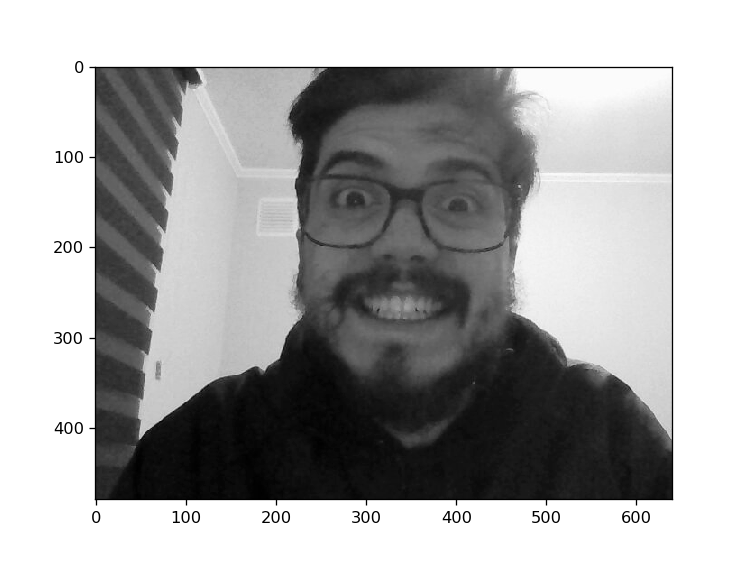

In [116]:
# to grayscale
img_bw = 0.2989*img[:, :, 0] + 0.587*img[:, :, 1]+ 0.114*img[:, :, 2]

plt.figure()
plt.imshow(gray_img, cmap=plt.cm.Greys_r)

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

<IPython.core.display.Javascript object>


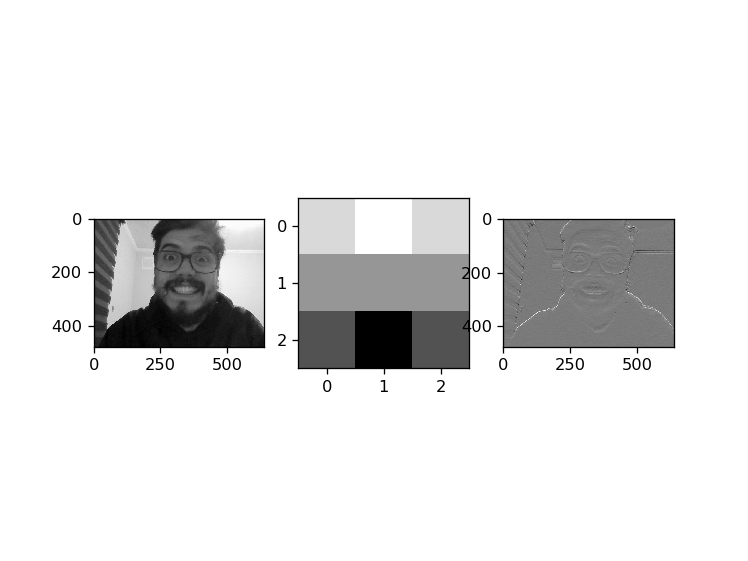

In [144]:
dim_kernel = 3
filt = np.zeros(shape = (dim_kernel, dim_kernel))
filt[1:-1, 1:-1] = 1
filt = np.array([[1, 2, 1],
                 [0, 0, 0],
                 [-1, -2, -1]
                ])
display(filt)
img_ = img[:, :, 0]
conv_img = scipy.signal.correlate2d(img_bw, filt, mode = "valid")
fig, ax = plt.subplots(1,3)
ax[1].imshow(filt, cmap=plt.cm.Greys_r)
ax[0].imshow(img_bw, cmap=plt.cm.Greys_r)
ax[2].imshow(conv_img, cmap=plt.cm.Greys_r)

# Neural network

# get data

In [3]:
train_data = torchvision.datasets.MNIST(root="/home/leo/Desktop/remove",
                                       train = True,
                                       download = True,
                                       transform = torchvision.transforms.ToTensor())

test_data = torchvision.datasets.MNIST(root="/home/leo/Desktop/remove",
                                      train = False,
                                      download = True,
                                      transform = torchvision.transforms.ToTensor())

<function Tensor.size>

<IPython.core.display.Javascript object>


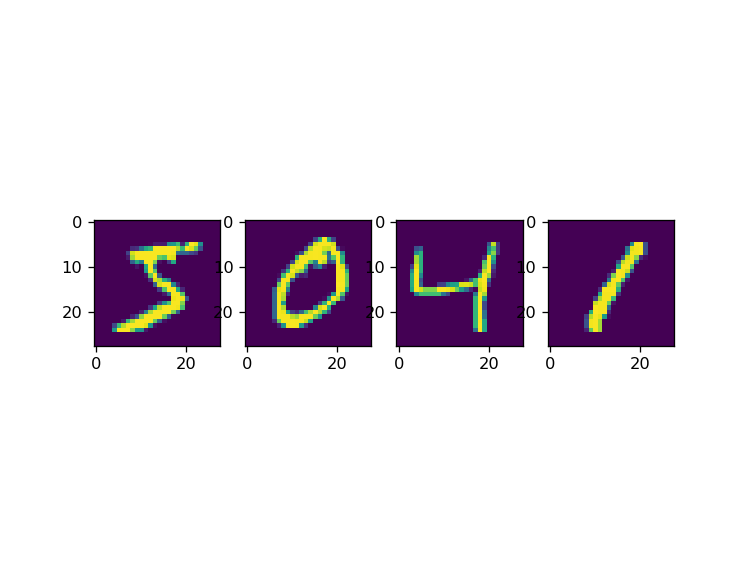

In [4]:
# display data
image, label = train_data[0]
display(image.size)
fig, ax = plt.subplots(1,4)
for i in range(4):
    
    image, label = train_data[i]
    ax[i].imshow(image[0, :, :].numpy())
    

<IPython.core.display.Javascript object>


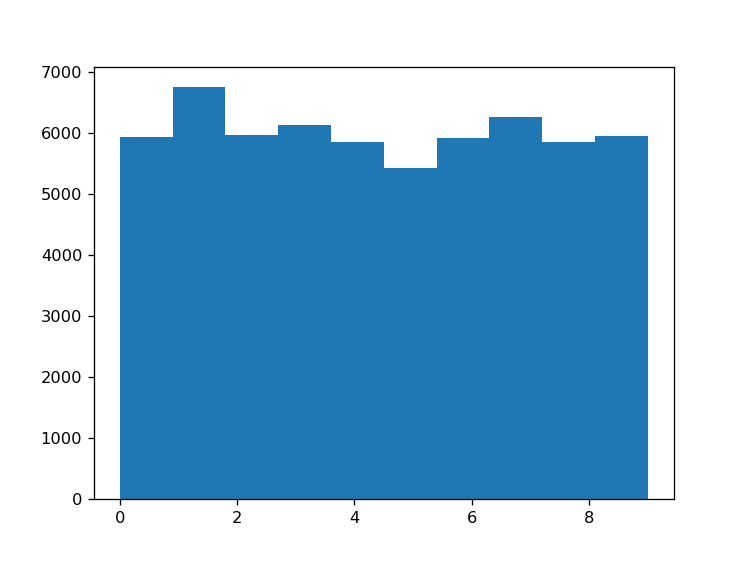

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

In [256]:
plt.figure()
plt.hist(train_data.targets)

# Define convolutional neural network architecture

In [5]:
class conv_net(torch.nn.Module):
    
    def __init__(self, n_filters = 8):
        
        super(conv_net, self).__init__()
        
        # Feature extraction
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = 3)
        self.max_pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # classification
        self.fc1 = torch.nn.Linear(in_features = 8*13*13, out_features = 10)
        
        # activation
        self.act = torch.nn.ReLU()
        
    def forward(self, x):
        
#         print(x.shape)
        z = self.max_pool(self.conv1(x))
        
#         print(z.shape)
        
        # flatten
        z = z.reshape(-1, 8*13*13)
#         print(z.shape)
        
        z = self.act(self.fc1(z))
        
#         print(z.shape)
        
        return z

In [6]:
# create model and move to cuda
model = conv_net().cuda()

In [7]:
# loss function
criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, amsgrad = True)

In [8]:
# generate train and test idx 
train_idx, valid_idx = next(sklearn.model_selection.StratifiedShuffleSplit(train_size=0.6).split(train_data.data, train_data.targets))

# Data loader de entrenamiento
train_dataset = Subset(train_data, train_idx)
torch_train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)

# Data loader de validación
torch_valid_loader = DataLoader(Subset(train_data, valid_idx), shuffle=False, batch_size=256)

In [9]:
def train_one_epoch(k, model, criterion, optimizer, train_loss_values, test_loss_values):
    
    global best_valid
    
    # store train loss
    train_loss, train_acc= 0
    valid_loss, valid_acc = 0
    
    # minibatch training
    for sample_data, sample_labels in torch_train_loader:
        
        sample_data = sample_data.cuda()
        sample_labels = sample_labels.cuda()
        
         # get predictions
        Y_predict = model.forward(sample_data)

        # get loss
        loss = criterion(Y_predict, sample_labels)
        
        # update loss
        train_loss += loss.cpu().detach().numpy()
        
        # reset grads
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # update parameters
        optimizer.step()
        
        train_acc += (torch.nn.Softmax(dim=1)(Y_predict).argmax(dim=1) == sample_labels).sum().item()
    
    # add train loss to array
    train_loss_values.append(train_loss)
    # add information to tensorboard
    writer.add_scalar('Train/Loss', train_loss/len(train_idx), k)
    writer.add_scalar('Train/Acc', train_acc/len(valid_idx), k)
    
    # minibatch test
    for sample_data, sample_labels in torch_valid_loader:
        
        sample_data = sample_data.cuda()
        sample_labels = sample_labels.cuda()
        
         # get predictions
        Y_predict = model.forward(sample_data)

        # get loss
        loss = criterion(Y_predict, sample_labels)
        
        # update loss
        valid_loss += loss.cpu().detach().numpy()
        
        valid_acc += (torch.nn.Softmax(dim=1)(Y_predict).argmax(dim=1) == sample_labels).sum().item()
        
    # add train loss to array
    test_loss_values.append(valid_loss)
    # add information to tensorboard
    print(valid_loss/len(valid_idx), k)
    writer.add_scalar('Valid/Loss', valid_loss/len(valid_idx), k)
    writer.add_scalar('Valid/Acc', valid_acc/len(valid_idx), k)
    
    # check if there is a better value
    if k%2 == 0:
        
        if valid_loss < best_valid:
            
            print("new best model with valid loss: ", valid_loss)
            
            best_valid = valid_loss
            torch.save(
                {
                    'epoch': k,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': valid_loss
                },
                '/home/leo/Desktop/master_UACH/2S-2019/AI/artificial_intelligence_master/supervised_learning/works/best_Conv_MNIST.pt'
            )

In [40]:
import time
from tqdm import tqdm_notebook

model_name = str(0)

writer = SummaryWriter(log_dir="/tmp/tensorboard/red_convolucional_simple/"+model_name,
                       flush_secs=20)

epochs = 100

best_valid = np.inf

train_loss_values = []
test_loss_values = []

# model.state_dict()
# global best_valid, model

for epoch in tqdm_notebook(range(epochs)): 
    
    print("epoch ", epoch)
    
    train_one_epoch(epoch, model, criterion, optimizer, train_loss_values, test_loss_values)

epoch  0
1.2500690771738687 0
new best model with valid loss:  30001.65785217285
epoch  1
1.2486467399597168 1
epoch  2
1.250316785812378 2
epoch  3
1.2540226675669353 3
epoch  4
1.2511548665364582 4
epoch  5
1.254680995941162 5
epoch  6
1.2526967913309732 6
epoch  7
1.251618288675944 7
epoch  8
1.2518896783192952 8
epoch  9
1.2510450827280681 9
epoch  10
1.2542799638112385 10
epoch  11
1.2509883683522542 11
epoch  12
1.2523537216186524 12
epoch  13
1.252255438486735 13
epoch  14
1.2515742766062419 14
epoch  15
1.2568618755340577 15
epoch  16
1.2536203625996907 16
epoch  17
1.2496020641326904 17
epoch  18
1.2557537053426107 18
epoch  19
1.2530243848164877 19
epoch  20
1.2543406194051108 20
epoch  21
1.2524480171203614 21
epoch  22
1.2537717393239338 22
epoch  23
1.2553099740346272 23
epoch  24
1.2558808320363362 24
epoch  25
1.2567312965393067 25
epoch  26
1.2561489028930664 26
epoch  27
1.2574139232635497 27
epoch  28
1.254369073867798 28
epoch  29
1.255435116449992 29
epoch  30
1.255

In [11]:
# Recovering best model
model = conv_net()

# loading best model
model.load_state_dict(torch.load("/home/leo/Desktop/master_UACH/2S-2019/AI/artificial_intelligence_master/supervised_learning/works/best_Conv_MNIST.pt")["model_state_dict"])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

<IPython.core.display.Javascript object>


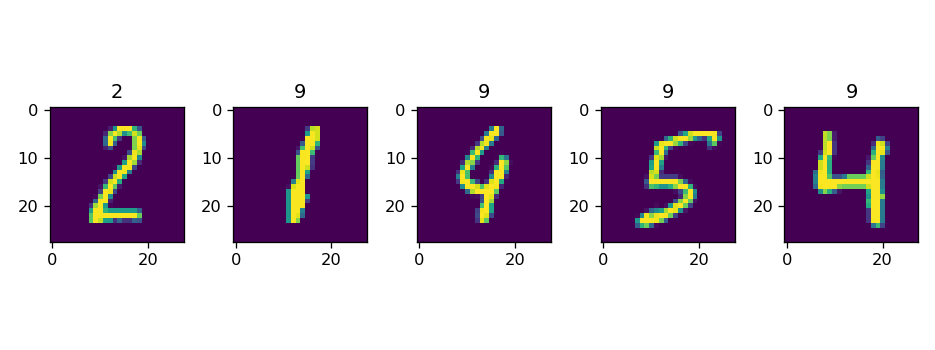

In [14]:
numbers = 5

fig, ax = plt.subplots(1, numbers, figsize = (8,3), tight_layout = True)

for i in range(numbers):
    
    image, label = test_data[np.random.randint(1000)]
    y = torch.nn.Softmax(dim=1)(model.cpu().forward(image.unsqueeze(0))).argmax(dim=1)
    # y = torch.nn.Softmax(dim = 1)(model.forward)
    ax[i].imshow(image.numpy()[0, :, :])
    ax[i].set_title(str(y[0].numpy()))

<IPython.core.display.Javascript object>


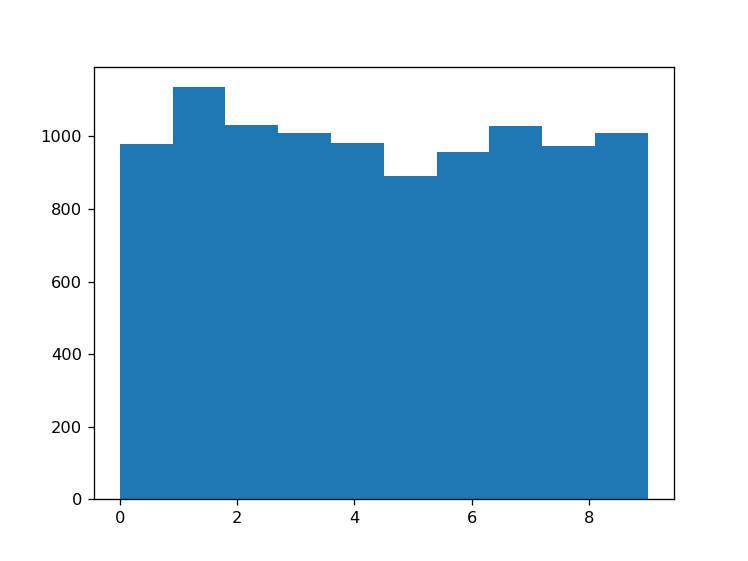

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

In [33]:
plt.figure()
plt.hist(test_data.targets)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

# testing on test data
test_loader = DataLoader(test_data, shuffle = False, batch_size = 256)
test_targets = test_data.targets.numpy()

predict_test = []
for data, label in test_loader:
    
    logits = model.forward(data)
    predict_test.append(torch.argmax(logits, dim = 1).detach().numpy())
    
predict_test = np.concatenate(predict_test)

cm = confusion_matrix(test_targets, predict_test)
display(cm)

print(classification_report(test_targets, predict_test))

array([[ 971,    0,    2,    1,    0,    0,    2,    0,    0,    4],
       [   0,    0,   11,    6,    0,    0,    2,    0,    0, 1116],
       [   3,    0,  996,    7,    0,    0,    1,    0,    0,   25],
       [   0,    0,    5,  975,    0,    0,    0,    0,    0,   30],
       [   4,    0,    8,    1,    0,    0,   12,    0,    0,  957],
       [   7,    0,    2,   20,    0,    0,    7,    0,    0,  856],
       [   9,    0,    7,    0,    0,    0,  936,    0,    0,    6],
       [   1,    0,   21,   12,    0,    0,    0,    0,    0,  994],
       [  11,    0,   24,   12,    0,    0,    3,    0,    0,  924],
       [   2,    0,    0,    5,    0,    0,    0,    0,    0, 1002]])

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.00      0.00      0.00      1135
           2       0.93      0.97      0.94      1032
           3       0.94      0.97      0.95      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.97      0.98      0.97       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.17      0.99      0.29      1009

    accuracy                           0.49     10000
   macro avg       0.40      0.49      0.41     10000
weighted avg       0.39      0.49      0.41     10000



/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


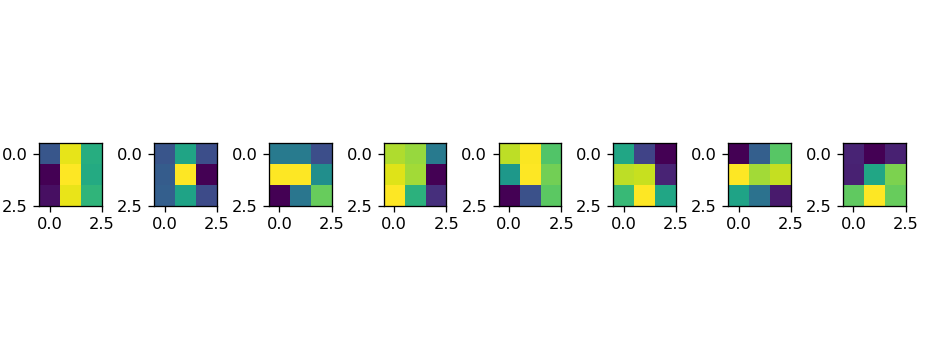

In [44]:
w = model.conv1.weight.data.numpy()

fig, ax = plt.subplots(1, w.shape[0], tight_layout = True, figsize = (8,3))
for i in range(w.shape[0]):
    
    ax[i].imshow(w[i, 0, :, :])

# Data augmentation

<IPython.core.display.Javascript object>


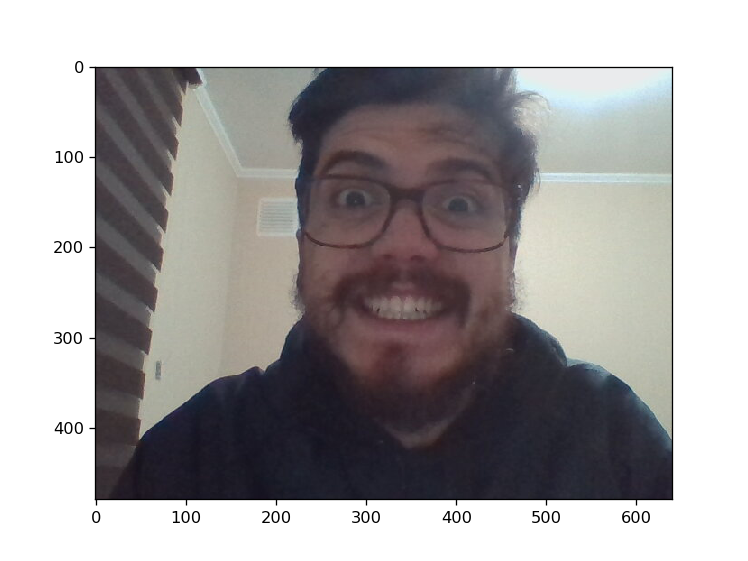

In [59]:
from PIL import Image

img = Image.open("leo.jpg")
plt.figure()
plt.imshow(img)

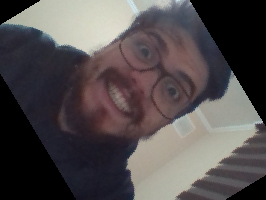

In [172]:
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(200),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.RandomRotation(degrees = 90)])

transforms(img)

# Pretrained models

In [174]:
resnet_model = torchvision.models.resnet18(pretrained = True, progress = True)
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [230]:
image_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUSExMVFRUXFRcWGBYVFRcXFRUXFRgXFhYXFRUYHSggGBolGxUWITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0mHSYtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIARMAtwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAADBAIFAAEGBwj/xAA+EAABAwIEAwYDBgUDBAMAAAABAAIRAyEEEjFBBVFhBiJxgZGhEzKxBxRCwdHwI1Jy4fFiorIVQ4KSJDNT/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAKxEAAgIBBAEDAwMFAAAAAAAAAAECESEDEjFBBFFhcRMiMjNCgQUjkaHB/9oADAMBAAIRAxEAPwCp0KMAg1ExSVgGpoeJ0KI1DxOijsBDC6lBr6otDdBraq7yBGjut0T3lqkt0hdJgWVLZHDdUvSKbo3BTAWcoQpOWilJ4HFWxaobrVVqjVddFKgsFlTNFBARWJvglojxFktVPw4w4hX1YS1UDO69NMktMXop8NddDrnuhTwDVTAHW+Yqqxwh4VtUHeVVxQQ4FT2IUf8AMsWgbrFSGdVVR6RshVAt0TZADTVDECykFvECygCsp7oNVHbqUGpqqAiwWW6IutTZTwwlDGN8k3hj3Sl8uiPR0KLAA4IL3JioEq9Z3ZpVAXCSjlDYLom6roUeSNMaojUNmpRKSiy3GguyoMa2Hz1XQbKm4szdXExfIxMsCZwAskcM+WqwweitiAVBcqs4uNFaP1KQ4y2wUICqpLFKkFisDq3aKOHW3GyjRsUAOhbraKMrbjZSBXblQqhScbrVdAACmcG1Kgp3CBDGNPFwt0nKNTULRskUSclSLpqbJbdZ1k2lwmaaFgCkxbaE9w1EE3VEpoY1KIxHRnqSp0EBSPFKfclOMQsY2WFVFmMitwWisaBsq7B6KwpaFUAMG6U40bBNNKT4wbBICtphYp0RdYqYHTKD7FTCjiAmAxmspF1kCm6ykXWUgKVDdRrlSqqFZMADdVYYbRV7RdWWFCADHVarKRCFWKSHZtxsgkqbyhyhoe7BOmt01qktMN1m1yaxnRB+pU2aKNQXW2lUuDGTtk2rKolpW2LY0Kkm7KahYnxViz5UhVbDk5m7qtDBMKV4voExTKX4tsmAphRdYp4QXWIGdDF1J7JClUEGVKZ0RZAtTEWRH6KDzCsMGRTomvALy406eYS1haA59QiLkBzQBzJOwSbrJUVboqD80HXWNz4DVWlLsvjarc9PDvLSJBsJ8A4glVmHxdMZ/hTnJ79R4a9zydzMwOmo5kr2zg1cYXAU3135slMF7gPxalrR4mAkpOynFJHnGC+znHPylzadMHXO+48Q0FdNw37Ng0H4tck7Cm2PUumfRVnEftfY18UqOZu+c5XdOi6jsp25oY0imWmlWicjiC139Dxr7J2JpnH8Tw/DKb/hfExDXCxcQ2AerSAbIeK7G1iz4uHezE0zuzuvHiwn2BJ6Lq/tD7KnFUy+k0GrGU6CRsSeipfsnxDqFSrgqshwGZoMwctjE8wQY6FZpyi8m7jCULisnE1BBg2IsQdQRsQhFev9t+z2Gq0atdwyVGU3OzttmLRIDx+KTA5rx5y1OcK0rShnW8ydYA29y0FpxWSorABWORWCyDsmm2altApOJHK9SL7IvFKciUlh37LRKgGKSTx9XMYW8TVISjTJQNDVALESkICxIC/xL5ahYV1lEkpdxIKdYJYcXKlieHVsZicNg6bwxgomo9/4WML3ue945/K3/wBQt04AV1hsVTwmBr4qpmz14w9ENgE5M7i6To0OcfNvOFPY4lNWxuCwtT4eFw33ksdHxa5c5r3SAXMotsADuZNjYLteAdvqb4oYuhTYx7g3MGxT7wAAex8wJ3nyXBdm8fSdXpsqtpVW1XNZd1RuSSATmbBzcjcL2jAcOwrKRpNY3I5mR4t32xBLhEE6EmLzKp7VwaRi2rPJ/tT7G0sJWZWoANpVphhEtY8XIEz3SCCBtDo2jk+FYh9F4IdabamJtbfdew9veDkcMey7vu9RtRs3/hiRDTNxlcfReQ0GOe7K28DMNgQOcrNvFAlWUe0fZr2sqYoOoVoL6bRlfu8aHP8A6tL7o/EcBUdxGmaJDCzvOJ0yb2GsyRHVcD2ExRw2Oa4nKx5ykncGw25lui9hxtACtTrbjuHweQ36keilxvkcZOLx2cn9p3xjRY6HNptqFrwCCHA5Sx5jbMCLwZ8V5k9fQWPwja1J9J3yvaWnwIheE8c4TVwtQ06zSDsfwvH8zTuPputUzIr1uEN1RTpS7QE+AlWwJWhboiVp+Hqfyu9EcYeq0SWEDnqPZIdEc10So/ZLxdac9Agj7hUzzlcVZOekca3dIBfGOmFDLCg4yiO2QNDdFwhYosC2gDoAAk8aBsrEUwUpj6NpUJhRBrbSme14acThMMZNOnQ+XQZ3B5cR1LhKXwYzCEt2xqu+8UXk2FNjZtZxbJKJMvTAf9ADSHMqZYIM3zbkEHmu/wCzXG3PbSJrNlrSKoLZMiQHGdBLTp/Oei8+biXGRO3+PzVx2Rx4Y8se0HOdTs7cTy8eax3nRCSUqXZ7CKrX0HMc0OBZHdcHUyIuGnUCx1Xi/EODPoValEAuFEmmD/MHODmD/wBYK9b7O8NpMaXNY5pym7nZhDgflvcXSHaTD021C92lRwc7lLGhkGfP2V9WZyWWkcBw+sfiUqGUOkgkQPE7Wj8ivbmD4rBIj+3KF5jgXUvjF9NoAcbHeDr5G69Fw2NaA0DQD3STWTNlmJ/f78VW9oeC08XRNJ4E6tdF2O5j6HoU5gy/IC+MxJNtgSSB1IECeiOtFwZnhfEeFMw9Q030yXttDj3bbiNRf3QX8ScIAAA0AFgu2+0o0nVGNkZ8pzgC4AgsM87lcNVw8uySAZAnYzoT0R9SsG6jatBKWLBIFQkAm7mgEgf0nVejcE4ThPupf8QvaXH+LBGXb5ZI8fFeY4rCPovLHtLXDUbiRIcDu0ro+xHGPhvFJz8tJxJcDGQmIOadARYo3LgGmF7VdlHUQajW5qevxKf4f627DqLeC4p7I18jzXvXBsKGN/hvaaBksbHyhxJLQeQMrmO0vYBjy6ph4aXXNI2bO5pn8J6aeCawZt2eT1EHENEI/E8O6jUdSeIc0wQUu/5VRBXgXW3G6jKk3VAxqkbLFHOAsQI6rKoYhvdUg5ac+xWNhZX4LUhVnabiIOIa0tIazKLj5hlyy0bhWNEd9WZaCqmUpNHL/Byw4Tl28PzTeUWc3xXednOzlCvSq1K8gGadOLQ6AS/rFhyuVyGI4a+i4tI31HynqFhOLWSk7GsB2tx1EhrMlRo0DrbzB2nqrHj+Pr1yx1UBoLG2aSWzuZ3MqgawiDAXSYfEtqUw10WRvbVD3N8mcLcBEHS6u8Fx4/eabCYp5gHHlNvzBJXJMrZXEM05/oncEQXAbz6lTYj20LFQcDx5yDM4kQACReeVk/jcbkpuqC5AgDaevL+66ouyGjz3t8W/e3ODxZgBBINzsBeBEclyGJrSMw/pvra4+qscaA+s6rUdJc4kzpcmxi3IXSvEWANJaNQRyuOS55STkdcYtRLXso/D4pwwuIkE/wD01AYc0n/tmdRrHpur/Ddga1HEMe17X0wZOxPQtMjpuvL6FWHWJBEEEWIIMgg819BdnOI/eMLSrTJczvf1N7rvcFbRMJtrJHgUU2fCAAa0vtu0F2Zg6912qtly3FXltRpDosbDQzoT1srDh+ONpMyta9DGzgftc4OPjMrgfOzK4/6maexHovOnkgEFe4/aQ0HB3F87Y6GCT7Arw/iBgqUMrlNrSVGExhgn2M3SZGqxGAWJiL/MsQ3VFA11hTJoL8MIjSl/iobqxRTA7fD4n/49Jrflaz/cSXO9yVT8QJOoMc/1WcBLjRsJLXEet/zT9Rktg/RVLJcWc390myT+EWmF1OCoQ4g+SWq4GXErJwLK2lTMLVEODwNV0eG4TIQGYANcf0S2g1Re8L4gQ3KTPXfy/e6a41xkfB+ELvIki8xFrjRVeCo3sL/Tf1UscWtIzN714cLGD13C6IrDRN5VnL1y1xMhoIESLnXdV9YjMWAgiRN/IlWPGK7WkuAvvcb79d1R4N5L51ETt+wuVqjqUrEnmD7eY6L1r7HMSTQrUz+GoHDpnbB/4e68n4swCpbcgx1i69a+x7CObhqtRwgPqCPBg/UlbQdmWpxQTjmMDcQ4DSfff3RcNjIId9FynEeI/ErPdP4j9Vc8IqZv39FSlkyawdN2jwjsVhHNbdwIe0cyNvQleFcWZBjcGF9DcIIAieS8G7a0Ph43EM5VXnyccw9nBaEnPuVjQo90JFjZKtiyAAhcjYAm6xSYySsTJLh9I8kN1Por2mRcQCgvheevIa5Q5NftZTfDK18NXhotiU1TwFM08weM83adgk/LrlEJkeyLHH4jQLCCZtrI9bI/FMQA6NYm2h9Ux2fIFOsALkt9gf1VBxCnBNzPU6dF1qW6CZUchqXFG7SDyN/dYMZOYkxAnxi1vVUL6/ejdFqPUbmXRe4TtAWmIsnhj2vNvP8AVcZnhbbiHDQqd4z0WhiA3u3B8LeZQsazPYkDw19VxeBxzgQAY6aA/oV1fDOKUiQ1zXE+Qk+I1WkZ2FCNXg4qB2Yu5dPO2i5jFcOdh3ETI5jfzXrvD+GB4nIADyM+soOO4BScQx4zA89vArWUFNCUnFnmvZvg1PFvBe6MpBI5g6j2Xr1Sqyhgqvw4aGU35QLQYgR5kLi6XBmYTEPLXWc0EDk2+vO4N0XtFxFzqTcMy5cQXeAu1vrfyCz3KCaYTleTgKL3NdkPrz6rsezzyCJNlTcV4FVpgOLbgT5I/AMZcBZQmnwynFrlHp9B9hlvHJeSfalSy8QqH+dlN/qwNP8AxXrvBMSwtAAEryr7X3Tj7f8A40/q4/mum8EUcdhjBBVpUfKrsFTLjCsG0XaAJJqwaZGg26xbYYK0iRDR1Ad3piBHqhnU7rGVDqegAWOxDRdoibX26ryeMGbtux93DXua14cyCJyh3eAHRV1Os2Ym4V92R4X8UuquEwYAIt1KewnZxj6zw4iQbsiDlNweo8Fh9aMbTfB0R8dtJiXZ2sIc3Ukg/UKn47Th58Vc8ZptoYlrWkQQLBsR57pDjdDNDgvT8ae/SQVTaOWx+HjZXXE+G0y3NRBDhct2I/08j0SWKpd9oN7g+l03Te6INr6/qs9eTjJURqSaeDnqhQxUVzxPA5++wQdxz6+KpHYapPyO9CmppouMkwmdXPBsQJ73l4qjqUns+Zrm+IITXD3yYWkWUez9nnOcB35blEHqrupSbluJgHXVU3AagFFh0BaPpurShiwXAey7CEee9pMYHYwgS0BrW6bgT+fsl6+FgZqbpdrJRu0BH3nESWznOvtCrqONyj96LxtfUc5Ox24O5IlV4hUd89xoqbFU/h1Q5ujr+B3VkKog+KT4gP4cxoQjR+2VIz+o5SOx4FjXQFW9rKTa2Jc4gGAxs+DR+qruBYwyArTjoFPEVGl34hYdWg/muvXk9mPUepfQnwngbXvygBhiZdorHifZw0W/EBYQReNlXCu503R6DmCxJIO0/kuGOpJYscNZpOKKzE8JloflgaTzWlYYlwkNDraxOi0mvIkuzNp3yVeFpuMkHw310gKNTCOh5Fy20bGdwsZiyCbQ3SIPgESlXgkXktHjzPlaVatOyk+zVHiNVlnPqU+6BY92PAfVNMxmIa5j21fiuPdlpGYAmzHSL6pP7zmIzRObXmNwfCCnS+nJLZAbYQYLXEmDPOymTjK7Sz7I2XkSO/q9nG4hrH1iW1Q1oOUiBF49SuS4gwwQbEEg+IMH6IH/AF+uwE/FeXZA12c2Eb+IMI1Wo7LNQ94gF3MucMxnzK6PGdfbQJqTbRRubNQW0Bn6JxmDdVeKdwCYkaAc0o2v3yRaOdxbaOpW6GPdmcWu7wiY2PIeFlHkbnLBm/zOnxWEwOEpim8ve87Tc7f+IXO/GGabAfNEXF7eKTcSXFziXXmSCTJ59Uyx7A65N7A/SRsuaEWlnITludpFvh8MzFAue4DLrYAERMRzVUOHUjVORuW+gm2yXdjADcyNToL7WXQ9mKZqVTUtkpiSbkOJFmjmd/JdOnGTaiiZWWvDq5FJjSfwgX2iyawtUl4AOp5dd0DDYfM2QAfFWXCcJD2nr9F6XZZx3aRzX4itAj+I4Tzy923oqygwBwB00n81Pi2IPxKo1cKjzPLvGYW62Ka5sCRJm/4bCfXkvIknbMuXbJ46g3RhtsXa+gSVSpNN7CNRboRf8k3SrNA7wmLAh2vtoo4nK+BpqMo08kRj9yLVPgY7JYEZg43v5Kw7SPacRUc8Q5waWhutmgd4eSc7HcNdsLc+Sr+PPDcVWvPey6XEBpF12eVD+2vkc2UtKqdraqfdsTqt1ajoykd3NmsLibG6J91gEwC2JzZogLhUVeTKMVeRzgfC6dZ+V1XLInSb8rrEu7ClxaaTXEHSSJ0vp6rEpQaZ07dMp6mKBAAkHmdLctxutCtBJJuI+Ug9REclnwN7eP5IDaZ21kX8P8rTBz2DzanNcTMbzKYbVAg2lxmedraFJvYRPdtpA23jwUHYuDOpiR3TlsY5QYLSL9VUY2M6ns1wCpiSKju7SDgM14cSYys531OwXZ8fw9FjfhgAmJJPzE7k9Z/cLkKPbR5LABDGPzC0Wyd1pA0AJcDGzykeM9pX1s7haQSInu5ocb73BI8V1QnGKpGunS5ZScbxLqT3tbvBB2vKV4bj4AYDETM7k6mTadPRFzk/MZB2NzEnNrtJ9+i1Swg05ctwNj5SsptN2Epp9FicS0gNiBrbpy+qjnD5JdlE8pkkEjfctA80FtJp01H0Gv6KTcOCbaQfZZWlwRuQrUbBdofPXp4q0wHHn0aNSky4frzaZ1HWBqNFWVqPIcv8nlZCdpGU6jXXyhaRlXBSZ6/2TJqU2Cf+20jndoN10eGwpaRPNVnAcPSweGpGrUaw/Da0ue4NaXQLSVa8YxGSi9w1y28TofLXyXoJ0gZ4dxHGOGKrXsXvnnGYgBYMTmMa21HT9lIYfCOMucS4uu4zcE7Hz3RaUjVpnyGniuBpN8kyihmtizOWOg2E9VZ4B4DS83LSIYDLyTI7rdYiSSbKoLQ4iQW76WJ58k6PiNALXOFstjETc25ZbpYiwjt7Oz7Idov4rWPY5mcwIBynNGUnefKLql7RvLcZVG7qronpBGnj7Kq/6piHOa41DNOcpEg85tpoFKnjHue4vaHucHOkjvZiDcOFxrvYpak2408lupv0G3uBG87+f7KYweO+ESTSY4GACW3A5Jag0VXE0pkQchPKx8f8qTqLw2XNMcyDBvIgjzXIpxn9vfp2JwlB3/sdr495IeGsZGhDYgHnBWJP4rT80WFrwTuZEc1pWmo4Jlbd2ICsIAPm7kOR6QhVnAnQga2FomNVo1DMRd1yeUjTlotOe0M1FxeOc6H97KyXLFAq7TJvcyPMf5S1Sm74ckaBw6GTa/Q5/Nqstwco1NpvoQIAvzUywFobBMS7pJADhHKWtv0PMw1MbzhlTTwr2gTuwEQZME2kbHX9lEe7MGgkWFrSI6+8ePUzZ1acwMuUy3WZjRsGP6UtXYJuGkEjWZBAO0X9Z0QpWNoB92JJcAJcb6WvMAT19kcYVsFt5gGQeYuLjwWiNp9PZTa8ATN5HP8AfRJskIMO1lnTd2UxEgT7zZAa4EwDBD9BMAHm7lpdWuE4O2oxlR1VrGAGSYM5YgBsiTfYn5T4Cr4mxgeWsLi4ENL8zSHAjukBo5HW9yoWot21FOGLIuYJMGx01vHlbkrDs5w9jn/FqOGSnBy/jeZHda3wvPh5VgcW9YIm9j0keCbpFpYGAwXRJJAbmJnXYRlknaTsrUmnYk6PScZ2jo1CKWX4lMghzhBZ8ocQZs6xncHKYkwuO4N2hqNpGjUeXZQGNJILWMax7bD8U5zc8m3tCocXVqtcQBlmobCYJsbGYsI0tfqoUZbMZO8CIzg2sQZnW++kBX9Zyybaa3JoLRoObJNu7Gttxy715R/u5N4aZn5QOnkNRdaGZrTeb23BjS41gTotPrNERz3uBPLcT+SzVsxbZGrTgxBBgT4kaQOseil8JzY73zXAO2030EdVsVwQII2trzv6IlOu4EBtRw0EjQxHWP2Eg3ILUw2W/k2dHWgh0C+v+7bVVmBxFZrgXNsIMgyGgnKS8CTHdI8lavqOf3nOzBrXAd4yYBgxrYtb9d5VXUw5Die/BHeAccpl7QRz5W5Hpdxvs3jONPBulXdTbmAmHxnZ+B7dQZux0h1jGu66XhnGqfwSDTgwB3WHIbWzxoT+mi5Gg+ox80i5jiMgLDLi1rpg2hwIBseSNw/FUn1Iqfwqx0exrmhxaYy1KQtMj5mxcaKdbxdPWpvle5vozjwnXydBjGgn+G1oc1xFycxkEmHEiwBHLXTdYlamExLSQYc0wM7QXaCQSLOEx/NsdlibhWEZS03ZX1XiOgdt+La55wY81puWDIiSTbkOfjPsgyYiDJvzIm8keC0CSQOYBjqb/mFTZyhWaTfa21kyH5oB3LoPX5j+iANBJ2EHwt7X9FL4ny209ptI9EkCyM/EcwxMEtEna0DyBEeftlR7ZjI3UweoNz1F/wDaEk/ETfYt9IMDyiVN2IB7w0AjzcdfYIaSYrIvYLmdPdCqH99UUG0np/geqg5ma3j10GyAJmhmhok7GBeOnK5QhQJnUfkP3Kbw2MyxGhjy5/X2TeIv4k38tf31RlPJaVlUGkGP3yR2RmmNreZm3I2WsQREjTQ9CLf380tnNzvpHiqJHXVQ4wbgQA03AB5eIUPhNBsBYD+/1CDWZl8YH0t9SiQYE6yT6WSfOAymbcABMG52/NRewBrmgwTBB11Bm+x2smXUxHqfW6wXItbKGj+psH1zfVTkPcBh8KTtEnKCdZOv0j1W2uAJA+Wd/Hn4AIuLe1o7sjvBwO9z+X5pOq4gkaXFvGbD39FSBoabV709dNYnkfAz4qTqpky6QIOu/wCIjzj0SWKEOyg36egH5rHtIDQb6mx5mP0Q+cCyGoGAXRcggc+Ue5jzUXUGgB0CWhsOga2Jjy+imajWiBEhzp5XmHev0WME05JGWA6ORgj6x6pcAixq8WxLRmGIqaATm06DpH1WKvr1WuAAMOGvIjbzWIsabMc12YhpJJNotYzc+i1Wblh/4i4xHLSfVMsDfm0vMC1n6x4EhIVa9swvlfAnYSDEeJSWBvJESBB0mOmtvoUR9MmIIvNuRmIPmZ8lrNLb63JPmYHsVCjJe3a8TyJtPqrfqJEqrTlphosd9JiQPAXPjqpU6Mthu5JJ2ho/ufVMUqOacv8AM7f/AMmk/wC4R0W6tSLWuzLbYggn3BHkpsbQqHGI6R56oubQaW8vXyUaJB2sFBzDExoPaUCQRjRlG4vM+qYLpj/SPYD6pMWtHTymf1RsPUc3vDXruFTGpUAq1Dc3/Lr+ajTIkwDePp/lNYqsamsa26fuFqk4chv5fuQlYRQOq64PTXwR2gfQf+2qHSd3TuIMedp8iQtkGLm8N/IfokmJuxiAfRRaBExuBOvn6FQALR4x/j2RC7ux1BHr/ZDFZBmFcSyATrMagX/z5hQfTOYiQSQR3SJsDE+is8PiWtYJHeObxjui5/8AGfNIVnAOtr3p87H81Nu/YrFAPhyQbAkNEi9jlggeqLXAax2XWWtvqBZ0nlcIlJ8DLY6tB007zT0+UDzSdRxf8Q829JsHOIcNQND6KkKrCChGbcgT6AfqUMNiWxAg7yAfHlIlL0K8AbTDj1yjSegdHmETMASNZBNtibb7RB9U/kVgILTBFhM+J/wsU3MtBNic3kRbz0WKnTEyxFPM4tbMQ8GbWzCB4zC3Q4VVfSBLQGlplz3NpA5e9LS4jNJA6deTPA8XTdiHZwCz+Ie8YEOzBx9Hf7UbtHxSlWEUwSKWXKXawB3tbwYb4ASdRHPOc1JRivn2NoqO1tlHhmGTJ8fH9lbva+8npv7WQxRMciT7bT6+yJHePgfQLbPBm8DLu6LR4joRDvdAqznJ/cO6HVFrVWnLGhtfXkfIGfRNVqbQ0ucZMATyJufzU3QISpsjXTNttm0HsnKEFuk2EHpvPv6JGHOJc6bgH0ufZM4d/cidreHXzkJ0NIlWYCJty/fuli+DCZe6HC2ttbbbeaSqXIgW59FaVi9hl5aROhkCOY2QKpNuZJt5gAe30Q5OnnfaD/ZHIAYTrcR5HZJr1EyVmtG8F4jqLwekwtgEtuLCCDuRFp8oQXULPLvH8j7uW2GxZcwLWg2Iyjx0UtAkPOZNxyv4obTtzn11/NAoVAJ1mLqwdhXZQYJa8HKQLTPy+xWcntdNl1ZAg93funwGshCfsQLn9T9U+3DZqZrtgNmI6O7v1lJ4bDOfB27gjfvA5SBuJsiM1LjrAODRjqZNRrerYA1PdNvdNu4I2lTdWrF8fEPcYA2oIdDiXO+X5XaTGuySqtNKuyTEFrTBA7sAG52I5qfFu0lSs4tdZrmPEAXyvMk6XNxpeJ6pan1HSjj1+CobUnuKl7QapLA4AGwdBN7w4iPUAaJGriYfbSczeZabuE+J9D0TObunUzAJ2AG09bDyShwfxHNLSQflaN55e49YW0Y2TGm6ZZfFc5p0O58zvziPdaQWYoNa6iC2A67oGaqbHOHG4bOjeRG8rELCKnCnRmHMPeBYSR5GxHufVam9XoGx0uB9AFixHRkuR4jut8QsrfgG1/cysWIsqZAtENHT+6m8/P0AI8QdVixDEuDWGeTmn+VvuAjt1H9RH0WLEn+IDv3ZpcSRpfU63/VU1N0z0iPNzB9FpYq/cJckMRYOjYD6hEDzk8h75f1KxYlIOg2DqEhxJuXgHwyu/QLKDiWzuS6Tz7wP5lYsSfAdkxz3/suu7NVD91N9HOjpafzWli8r+sfoL5X/AE6vF/L+GI495im38JeCRsbFVzj3wNhkHlJ/RYsXT4f6Zet+X8IWxN335H6qtrWFUjZwHlGnsFixdr/FnJ+7/IGr3S6LWH0UsDZ7gP5D/wAf36DksWIjyxQ5QXhdMNFaoAM7IDSbwCQDE9LLSxYu/SX2o70f/9k="
url, filename = (image_url, "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <email.message.Message at 0x7f83841367b8>)

<IPython.core.display.Javascript object>


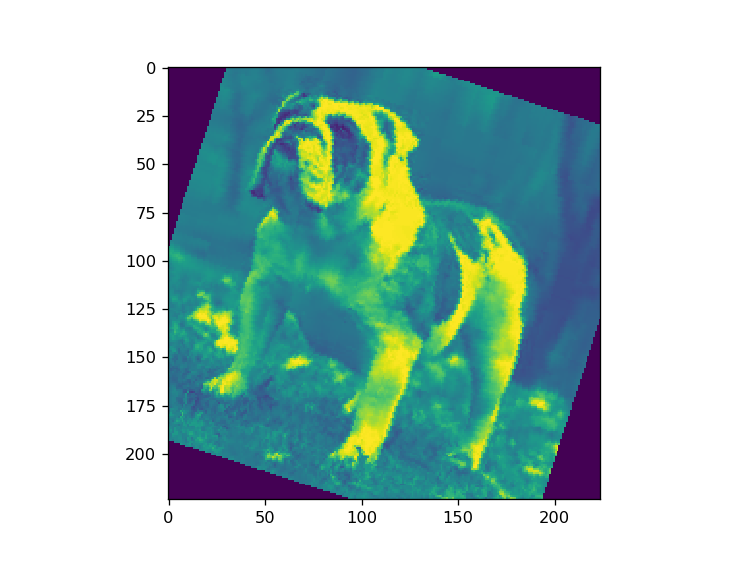

tensor([247])


In [231]:
img = Image.open("dog.jpg")
plt.figure()
plt.imshow(img)

transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(224),
                                           torchvision.transforms.CenterCrop(224),
                                             torchvision.transforms.RandomRotation(degrees=90),
                                           torchvision.transforms.ToTensor(),
                                            
                                           torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406),

                                                                            std = (0.229, 0.224, 0.225))])

print(resnet_model.forward(transforms(img).unsqueeze(0)).argmax(dim = 1))
plt.imshow(transforms(img)[0, :, :])